In [ ]:
import tensorflow as tf
import os

# Note that the `tpu` argument is for Colab-only
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))
strategy = tf.distribute.TPUStrategy(resolver)

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
from numpy import asarray
from tqdm import tqdm
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn

from tensorflow.keras.layers import GRU, Dropout, Conv1D, MaxPooling1D, concatenate, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model

from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
import matplotlib.pyplot as plt
from keras import regularizers

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
##Reading the Data File
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Files/training_set_rel3(12k).tsv', sep='\t', encoding='ISO-8859-1')
df = df.drop(columns=['rater3_domain1', 'rater1_domain2', 'rater2_domain2',
                       'domain2_score', 'rater1_trait1', 'rater1_trait2', 'rater1_trait3',
                        'rater1_trait4', 'rater1_trait5', 'rater1_trait6', 'rater2_trait1',
                       'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5',
                       'rater2_trait6', 'rater3_trait1', 'rater3_trait2', 'rater3_trait3',
                        'rater3_trait4', 'rater3_trait5', 'rater3_trait6', 'rater1_domain1', 'rater2_domain1'])

## Spliting the Data into its 8 prompts
df_1 = df[0:1783]
df_2 = df[1784:3583]
df_3 = df[3584:5309]
df_4 = df[5309:7079]
df_5 = df[7080:8884]
df_6 = df[8885:10684]
df_7 = df[10685:12253]
df_8 = df[12253:12977]

In [4]:
## Normalize and combine columns in one
column = 'domain1_score'

df_1['final_score'] = ((df_1[column] - df_1[column].min()) / (df_1[column].max() - df_1[column].min()))*10
df_2['final_score'] = ((df_2[column] - df_2[column].min()) / (df_2[column].max() - df_2[column].min()))*10
df_3['final_score'] = ((df_3[column] - df_3[column].min()) / (df_3[column].max() - df_3[column].min()))*10
df_4['final_score'] = ((df_4[column] - df_4[column].min()) / (df_4[column].max() - df_4[column].min()))*10
df_5['final_score'] = ((df_5[column] - df_5[column].min()) / (df_5[column].max() - df_5[column].min()))*10
df_6['final_score'] = ((df_6[column] - df_6[column].min()) / (df_6[column].max() - df_6[column].min()))*10
df_7['final_score'] = ((df_7[column] - df_7[column].min()) / (df_7[column].max() - df_7[column].min()))*10
df_8['final_score'] = ((df_8[column] - df_8[column].min()) / (df_8[column].max() - df_8[column].min()))*10

df_1['final_score'] = df_1['final_score'].round(1).astype('int')
df_2['final_score'] = df_2['final_score'].round(1).astype('int')
df_3['final_score'] = df_3['final_score'].round(1).astype('int')
df_4['final_score'] = df_4['final_score'].round(1).astype('int')
df_5['final_score'] = df_5['final_score'].round(1).astype('int')
df_6['final_score'] = df_6['final_score'].round(1).astype('int')
df_7['final_score'] = df_7['final_score'].round(1).astype('int')
df_8['final_score'] = df_8['final_score'].round(1).astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [5]:
result = df_1.append([df_2, df_3, df_4, df_5, df_6, df_7, df_8], ignore_index=True)
#result = df_1.append([df_7, df_8], ignore_index=True)
df = result

In [6]:
print(df[df['domain1_score'].isnull()])
print(df[df['essay'].isnull()])

Empty DataFrame
Columns: [essay_id, essay_set, essay, domain1_score, final_score]
Index: []
Empty DataFrame
Columns: [essay_id, essay_set, essay, domain1_score, final_score]
Index: []


In [7]:
df = df.dropna()
df['essay'].dropna(inplace=True)
#df['domain1_score'].dropna(inplace=True)
df.head()

,essay_id,essay_set,essay,domain1_score,final_score
0,1,1,"Dear local newspaper, I think effects computer...",8,6
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9,7
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7,5
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10,8
4,5,1,"Dear @LOCATION1, I know having computers has a...",8,6


In [8]:
X = df.drop('domain1_score', axis = 1)
print(len(X['essay'][0]))
max_len = X['essay'].apply(lambda x: len(x)).max()
print(max_len)

1875
6098


In [9]:
y = df['domain1_score'].astype(int) 
#y = df['domain1_score']
#pd.to_numeric(y, downcast="integer")
print(df[df['domain1_score'].isnull()])

Empty DataFrame
Columns: [essay_id, essay_set, essay, domain1_score, final_score]
Index: []


In [10]:
## df[df['essay_set']==8]['domain1_score']

In [11]:
#min_range = [2,1,0,0,0,0,0,0]
#max_range = [12,6,3,3,4,4,30,60]

#def normalize(x,mi,ma):
#    #print("Before Normalization: "+str(x))
#    x = (x-mi)/(ma-mi)
#    #print("After Normalization : "+str(x))
#    return round(x*10)

#df['final_score']=df.apply(lambda x:normalize(x['domain1_score'],min_range[x['essay_set']-1],max_range[x['essay_set']-1]),axis=1)

In [12]:
df['final_score']

0        6
1        7
2        5
3        8
4        6
        ..
12966    5
12967    4
12968    6
12969    6
12970    6
Name: final_score, Length: 12971, dtype: int64

In [13]:
df.drop('domain1_score',axis=1,inplace=True)

In [14]:
y = df['final_score']

In [15]:
X.shape

(12971, 4)

In [16]:
y.shape

(12971,)

In [17]:
voc_size = 30000

In [18]:
cap = ['@CAPS'+str(i) for i in range(100)]
loc = ['@LOCATION'+str(i) for i in range(100)]
org =['@ORGANIZATION'+str(i) for i in range(100)]
per = ['@PERSON'+str(i) for i in range(100)]
date = ['@DATE'+str(i) for i in range(100)]
time = ['@TIME'+str(i) for i in range(100)]
money = ['@MONEY'+str(i) for i in range(100)]
ner =  cap + loc + org + per + date + time + money

In [19]:
#from nltk.stem.porter import PorterStemmer
#ps = PorterStemmer()

## Pre-processing with POS tagging
word_Lemmatized = WordNetLemmatizer()
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

essays = X.copy()
corpus = []
for i in range (0, len(essays)):
    #print(i)
    review = re.sub('[^a-zA-Z]', ' ', essays['essay'][i])
    review = review.lower()
    review = review.split()
    #review = stopwords.words('english')
    #review = review.extend(ner)

    review = [word_Lemmatized.lemmatize(word, tag_map[0]) for word in review if not word in stopwords.words('english')]
    #review.extend(ner)
    review = ' '.join(review)
    corpus.append(review)
    

In [20]:
corpus[5]

'dear location think computer negative affect u many people ace camputer daily america num many people go least hour num mean num people cant exercise wasting many posibility physical cap sound good think everything done write letter got got material sit back done writing put material away put letter mailbox walk way back well think write email sitdown move finger see difference cap instead getting good walk friend house talk er know literally computer instead around add anything computer give away information information lead everthing wouldbe gone go online believe phisically get hurt computer long num thing computer cap happened grandpa wood chair day get ardthritis muscle cap thing th'

In [21]:
#onehot_rep = [one_hot(words, voc_size) for words in corpus]
#onehot_rep [0:2]

In [22]:
hparams = {
    "batch_size": 128,
    "cnn_filter_sizes": [128, 128, 128],
    "cnn_kernel_sizes": [5, 5, 5],
    "cnn_pooling_sizes": [5, 5, 40],
    "constraint_learning_rate": 0.01,
    "embedding_dim": 100,
    "embedding_trainable": False,
    "learning_rate": 6e-5,
    "max_num_words": 10000,
    "max_sequence_length": 250
}

In [23]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=hparams["max_num_words"])
tokenizer.fit_on_texts(corpus)
text_sequences = tokenizer.texts_to_sequences(corpus)
#text_sequences

In [24]:
sent_length = 1875
embedded_docs = pad_sequences(text_sequences,padding='post',maxlen=hparams["max_sequence_length"])

print(embedded_docs)

[[ 212  375  295 ...    0    0    0]
 [ 212    1    1 ...    0    0    0]
 [ 212    1    1 ...    0    0    0]
 ...
 [  28   16   78 ...   40  178   22]
 [2364   17  137 ...    0    0    0]
 [  19    2  101 ...    0    0    0]]


In [26]:
#encoding="utf8"
#with strategy.scope():
embeddings_index = dict()
f = open('/content/drive/MyDrive/Colab Notebooks/Data Files/glove.840B.300d.txt')
for line in tqdm(f): 
    values = line.split(" ")
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

2196018it [03:00, 12191.04it/s]

Loaded 2196017 word vectors.


In [27]:
# create a weight matrix for words in training docs
from numpy import zeros
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = zeros((vocab_size, 300))
for word, i in tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 34748/34748 [00:00<00:00, 428035.96it/s]


In [52]:
##Creating the model_1
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.utils import plot_model
#with strategy.scope():
def get_model_1():
  embedding_vector_features=50
  model=Sequential() 
  e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=hparams["max_sequence_length"], trainable=False, name = 'GloVe_Embedding_300D')
  model.add(e)
  #name = 'GloVe_Embedding_300D'

  #model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')) 
  model.add(MaxPooling1D(pool_size=2))

  #model.add(LSTM(100))
  #model.add(Dense(1,activation='relu'))
  model.add(LSTM(100, dropout=0.4, recurrent_dropout=0.2, input_shape=[1, 300], return_sequences=True)) 
  model.add(LSTM(64, recurrent_dropout=0.2))
  model.add(Dropout(0.2))
  model.add(Dense(64, input_dim=64, kernel_regularizer=regularizers.l1(0.02)))
  model.add(Dense(1,activation='linear'))
  ##model.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_squared_error'])
  ## model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

  return model

model_1 = get_model_1()
model_1.compile(loss='mean_squared_error',optimizer='rmsprop', metrics=['mean_squared_error'])
print(model_1.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GloVe_Embedding_300D (Embed  (None, 250, 300)         10424700  
 ding)                                                           
                                                                 
 conv1d_7 (Conv1D)           (None, 250, 32)           28832     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 125, 32)          0         
 1D)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 125, 100)          53200     
                                                                 
 lstm_15 (LSTM)              (None, 64)                42240     
                                                                 
 dropout_7 (Dropout)         (None, 64)               

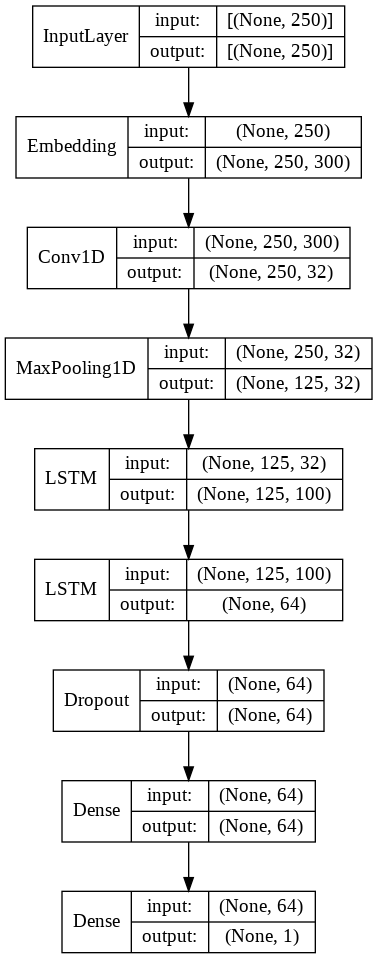

In [53]:
## Print graph for model 1
plot_model(model_1, to_file='/content/drive/MyDrive/Colab Notebooks/Neural Networks/Glove_CNN_3LSTM_model-plot.png', show_shapes=True, show_layer_names=False)

In [54]:
## Creating the model_2
#with strategy.scope():
def get_model_2():
  embedding_vector_features=50

  model=Sequential() 
  e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=hparams["max_sequence_length"], trainable=False) 
  model.add(e)
  
  model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu')) 
  model.add(MaxPooling1D(pool_size=2))

  model.add(Dense(64, input_dim=64, kernel_regularizer=regularizers.l1(0.02)))
  
  model.add(LSTM(100, dropout=0.4, recurrent_dropout=0.2, input_shape=[1, 300], return_sequences=True))
  model.add(Bidirectional(LSTM(64, recurrent_dropout=0.2))) 
  model.add(Dropout(0.2))
  model.add(Dense(1,activation='linear'))
  return model

model_2 = get_model_2()
model_2.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_squared_error'])

print(model_2.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 250, 300)          10424700  
                                                                 
 conv1d_8 (Conv1D)           (None, 250, 32)           19232     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 125, 32)          0         
 1D)                                                             
                                                                 
 dense_16 (Dense)            (None, 125, 64)           2112      
                                                                 
 lstm_16 (LSTM)              (None, 125, 100)          66000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                  

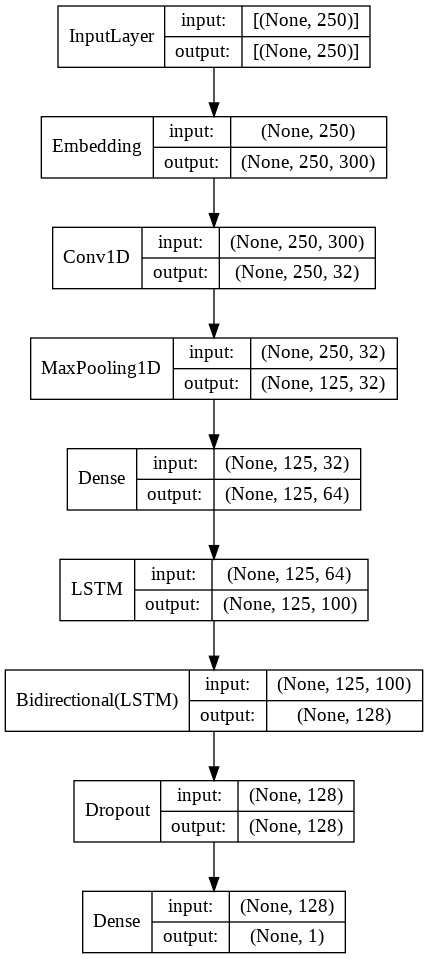

In [55]:
## Print graph for model 2
plot_model(model_2, to_file='/content/drive/MyDrive/Colab Notebooks/Neural Networks/Glove_CNN_LSTM_BiLSTM_model-plot.png', show_shapes=True, show_layer_names=False)

In [56]:
#with strategy.scope():
## Creating the model_3
def get_model():
    embedding_vector_features=50
    # define set of input
    deep_inputs = Input(shape=hparams["max_sequence_length"],)

    embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=4, trainable=False, mask_zero=True)(deep_inputs)

    # the first branch operates on the first input
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(embedding_layer)
    x = GlobalAveragePooling1D()(x)

    xx = Conv1D(filters=64, kernel_size=2, padding='same', activation='relu')(embedding_layer)
    xx = GlobalAveragePooling1D()(xx)


    # the second branch opreates on the second input Bidirectional(
    y = Bidirectional(LSTM(50, recurrent_dropout=0.2, return_sequences=False))(embedding_layer)

    # combine the output of the two branches
    combined = concatenate([x,xx,y])
    #combined = concatenate()[x, xx, y]

    # apply a FC layer and then a regression prediction on the combined outputs
    out = Dense(64, input_dim=64, kernel_regularizer=regularizers.l1(0.01))(combined)
    out = Dense(64, activation="relu")(out)
    #out = tf.keras.layers.BatchNormalization()(out)
    #out = Dropout(0.2)(out)

    out = Dense(32, activation="relu")(out)
    #out = tf.keras.layers.BatchNormalization()(out)
    #out = Dropout(0.2)(out)

    out = Dense(16, activation="relu")(out)

    out = Dense(1, activation="linear")(out)

    # our model will accept the inputs of the two branches and
    # then output a single value
    model = Model(inputs=deep_inputs, outputs=out)
    return model

model = get_model()
model.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_squared_error'])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 250, 300)     10424700    ['input_1[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 250, 64)      57664       ['embedding_6[0][0]']            
                                                                                                  
 conv1d_10 (Conv1D)             (None, 250, 64)      38464       ['embedding_6[0][0]']            
                                                                                              

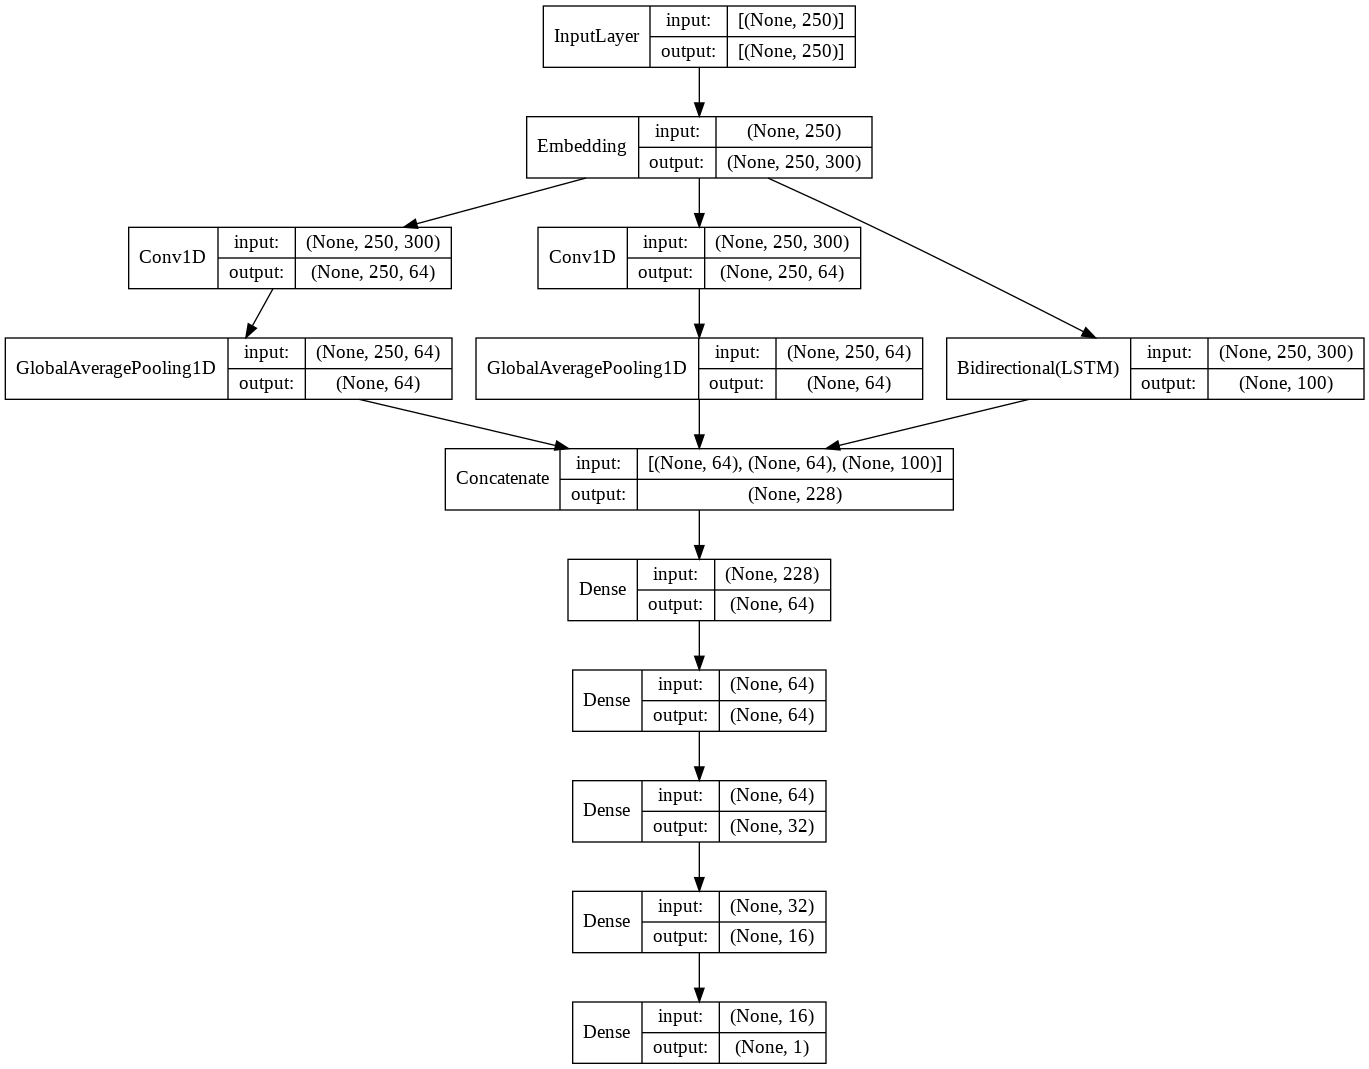

In [59]:
## Print graph for model of functional API 
plot_model(model, to_file='/content/drive/MyDrive/Colab Notebooks/Neural Networks/funAPI_Glove_CNN_BiLSTM_model-plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
import numpy as np
X_final=np.array(embedded_docs)
y_final=np.array(y)

In [ ]:
X_final

array([[ 212,  375,  295, ...,    0,    0,    0],
       [ 212,    1,    1, ...,    0,    0,    0],
       [ 212,    1,    1, ...,    0,    0,    0],
       ...,
       [  28,   16,   78, ...,   40,  178,   22],
       [2364,   17,  137, ...,    0,    0,    0],
       [  19,    2,  101, ...,    0,    0,    0]], dtype=int32)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)
X_test

array([[ 27, 286,  19, ...,   0,   0,   0],
       [ 27, 258,  36, ...,   0,   0,   0],
       [  3,  51, 616, ...,   0,   0,   0],
       ...,
       [101, 755,   5, ...,   0,   0,   0],
       [212,   1,   1, ...,   0,   0,   0],
       [378,  78, 189, ...,   0,   0,   0]], dtype=int32)

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train)
class_weights = dict(enumerate(class_weights))

In [ ]:
class_weights

{0: 2.5914085914085914,
 1: 42.87603305785124,
 2: 1.6548644338118021,
 3: 0.841456491768713,
 4: 0.9704451926674149,
 5: 0.7108309926697266,
 6: 0.3627972027972028,
 7: 0.5925079945180448,
 8: 2.0285434995112412,
 9: 5.044239183276616,
 10: 0.815979867882982}

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/Colab Notebooks/Neural Networks/checkpoint_2.h5', verbose = 1, save_best_only = True, save_weights_only = False)
earlyStop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, mode = 'auto')

callbacksList = [checkpoint, earlyStop]
## Training 
history = model_2.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=500,batch_size=64, callbacks = callbacksList)

model_2.load_weights("/content/drive/MyDrive/Colab Notebooks/Neural Networks/checkpoint_2.h5")

Epoch 1/500
163/163 [==============================] - ETA: 0s - loss: 2.0461 - mean_squared_error: 1.9138
Epoch 00001: val_loss improved from inf to 2.28424, saving model to /content/drive/MyDrive/Colab Notebooks/Neural Networks/checkpoint_2.h5
163/163 [==============================] - 11s 68ms/step - loss: 2.0461 - mean_squared_error: 1.9138 - val_loss: 2.2842 - val_mean_squared_error: 2.1539
Epoch 2/500
163/163 [==============================] - ETA: 0s - loss: 2.0252 - mean_squared_error: 1.8930
Epoch 00002: val_loss improved from 2.28424 to 2.10970, saving model to /content/drive/MyDrive/Colab Notebooks/Neural Networks/checkpoint_2.h5
163/163 [==============================] - 11s 67ms/step - loss: 2.0252 - mean_squared_error: 1.8930 - val_loss: 2.1097 - val_mean_squared_error: 1.9808
Epoch 3/500
163/163 [==============================] - ETA: 0s - loss: 1.9701 - mean_squared_error: 1.8391
Epoch 00003: val_loss did not improve from 2.10970
163/163 [==============================]

Text(0.5, 1.0, 'MSE wih funAPI_Glove_CNN_BiLSTM_model')

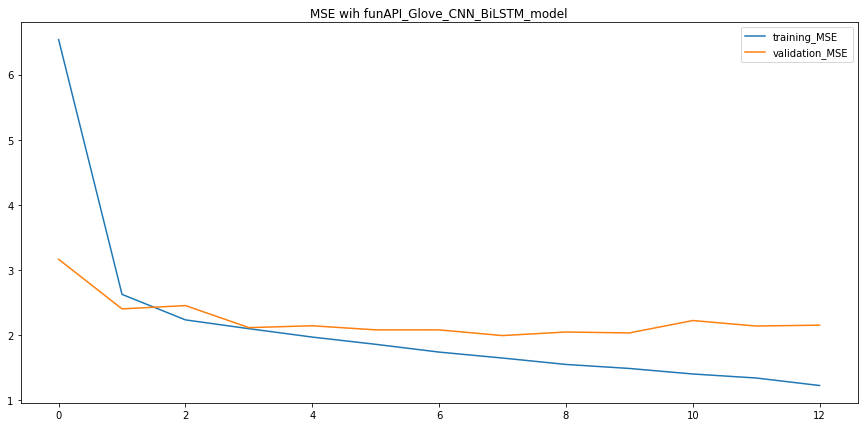

In [ ]:
#plot accuracy 
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.plot(range(13), history.history['mean_squared_error'])
plt.plot(range(13), history.history['val_mean_squared_error'])
plt.legend(['training_MSE', 'validation_MSE'])
plt.title('MSE wih funAPI_Glove_CNN_BiLSTM_model')

Text(0.5, 1.0, 'Loss with funAPI_Glove_CNN_BiLSTM_model')

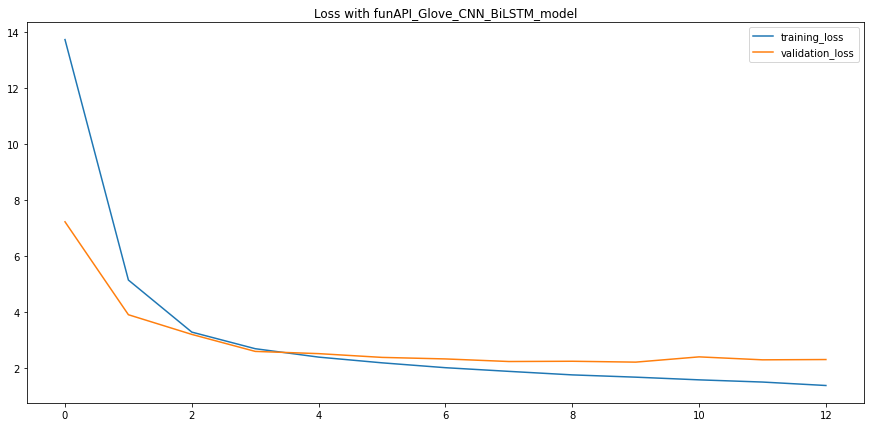

In [ ]:
#plot accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))
plt.plot(range(13), history.history['loss'])
plt.plot(range(13), history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss with funAPI_Glove_CNN_BiLSTM_model')

In [ ]:
y_test.shape

(2595,)

In [ ]:
y_pred=model_2.predict(X_test)
#X_test
from sklearn.metrics import mean_squared_error
print("Mean squared error:%.2f"%mean_squared_error(y_test,y_pred))
print("Root Mean squared error:%.2f"%np.sqrt(mean_squared_error(y_test,y_pred)))

Mean squared error:1.98
Root Mean squared error:1.41


In [ ]:
y_test

array([6, 0, 8, ..., 6, 6, 2])

In [ ]:
y_pred

array([[3.8426344 ],
       [0.04477055],
       [7.464879  ],
       ...,
       [5.326333  ],
       [7.339738  ],
       [2.5841973 ]], dtype=float32)

In [ ]:
#from sklearn.metrics import confusion_matrix
#confusion_matrix(y_test,y_pred)
# count number of characters 

In [ ]:
#from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
#accuracy_score(y_test,y_pred)

In [ ]:
from sklearn.metrics import cohen_kappa_score
y_pred = np.around(y_pred)
result = cohen_kappa_score(y_test,y_pred,weights='quadratic')
print("Kappa Score: {}".format(result))

Kappa Score: 0.8000298599405031


In [ ]:
from sklearn.metrics import classification_report
#print(classification_report(y_test, y_pred))
clsf_report = pd.DataFrame(classification_report(y_true = y_test, y_pred = y_pred, output_dict=True)).transpose()
clsf_report.to_csv('/content/drive/MyDrive/Colab Notebooks/Neural Networks/funAPI_Modelcm_report.csv', index= True)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


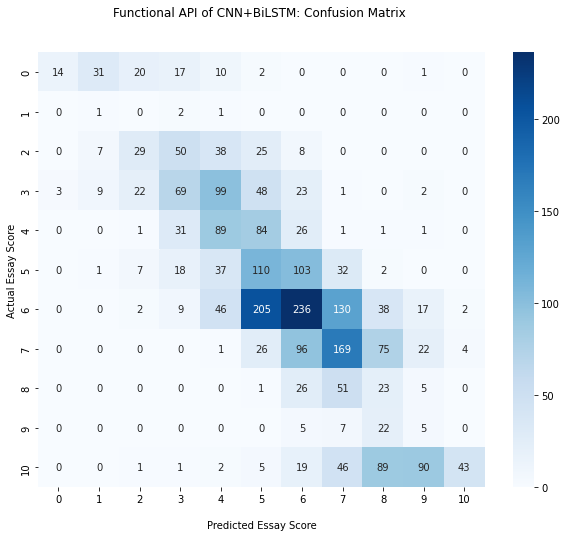

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model1_cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(model1_cm, annot=True, cmap='Blues',fmt='.3g')

ax.set_title('Functional API of CNN+BiLSTM: Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Essay Score')
ax.set_ylabel('Actual Essay Score');